#### Read all the query images

In [2]:
import os
import cv2
from src.utils.histograms import change_color_space, plot_histograms, get_histograms
# Directory containing the images
image_dir = 'data/qsd2_w1'

# List to store the images
images = []
color_space='HSV'
# Read images from the directory
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = change_color_space(img, color_space)
            images.append(img)

#### I don't think we'll need the function below...

In [3]:
def extract_top_left_pixel_values(image):
    """
    Extracts the values of the top left pixel in each channel of the given image.

    Parameters:
    image (numpy.ndarray): The input image.

    Returns:
    tuple: A tuple containing the values of the top left pixel in each channel.
    """
    if image is None or image.size == 0:
        raise ValueError("Invalid image provided")
    
    # Extract the values of the top left pixel
    top_left_pixel_values = image[0, 0]
    
    return tuple(top_left_pixel_values)

#### Function to choose an image to display (from the list of images)

In [4]:
import matplotlib.pyplot as plt

def show_image_at_index(images, index):
    """
    Displays the image at the given index from the list of images.

    Parameters:
    images (list): List of images.
    index (int): Index of the image to display.

    Raises:
    IndexError: If the index is out of range.
    """
    if index < 0 or index >= len(images):
        raise IndexError("Index out of range")
    
    plt.imshow(cv2.cvtColor(images[index], cv2.COLOR_HSV2RGB))
    plt.title(f"Image at index {index}")
    plt.axis('off')
    plt.show()

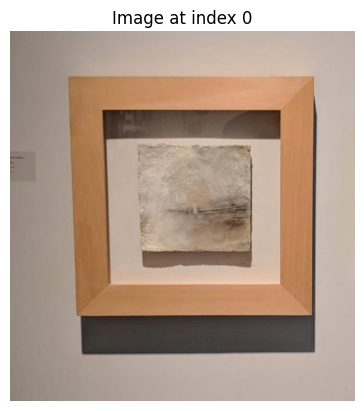

In [5]:
show_image_at_index(images, 0)

#### Image channel decomposition visualization

In [6]:
def show_image_channels(image, color_space):
    """
    Displays the decomposition of an image in its 3 channels.

    Parameters:
    image (numpy.ndarray): The input image.
    color_space (str): The color space of the image (e.g., 'RGB', 'LAB', etc.).

    Raises:
    ValueError: If the image does not have 3 channels.
    """
    if image.shape[2] != 3:
        raise ValueError("The image does not have 3 channels")

    # Create a figure with 4 subplots (1 for the original image and 3 for the channels)
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Display the original image
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_HSV2RGB) if color_space == 'HSV' else image)
    axes[0].set_title(f"Original Image ({color_space})")
    axes[0].axis('off')
    
    # Display each channel
    for i in range(3):
        channel_img = image[:, :, i]
        axes[i + 1].imshow(channel_img, cmap='gray')
        axes[i + 1].set_title(f"Channel {i + 1}")
        axes[i + 1].axis('off')
    
    plt.show()

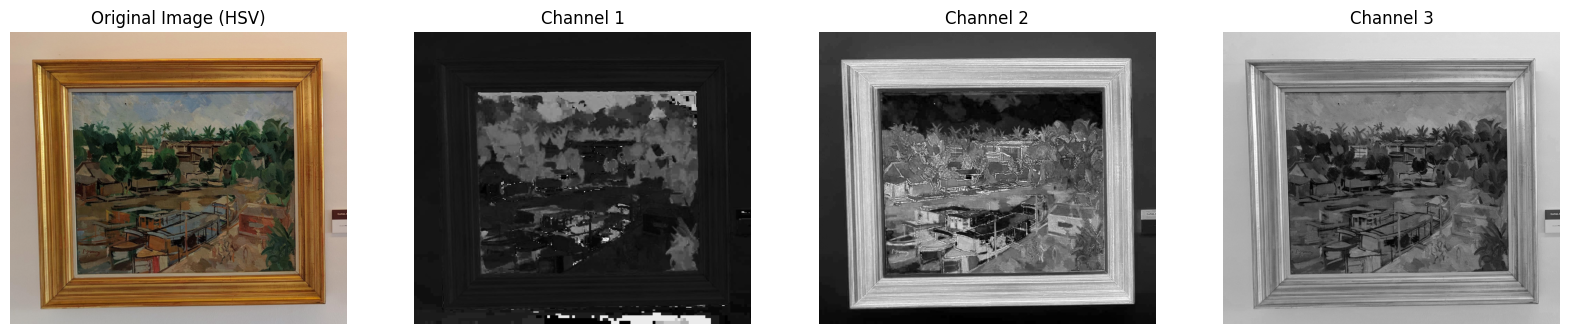

In [7]:
# Example usage
show_image_channels(images[10], color_space='HSV')

#### Functions to create the mixture of gaussians of the image borders' histograms

In [8]:
import numpy as np
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt

def read_border_pixels(image, border_width=10):
    """
    Reads the pixel values of the borders of an image.

    Parameters:
    image (numpy.ndarray): The input image in CIELAB format.
    border_width (int): The width of the border to read.

    Returns:
    numpy.ndarray: The pixel values of the borders.
    """
    if image.shape[2] != 3:
        raise ValueError("The image does not have 3 channels")

    # Extract border pixels
    top_border = image[:border_width, :, 1].flatten()
    top_border_2 = image[:border_width, :, 2].flatten()
    bottom_border = image[-border_width:, :, 1].flatten()
    bottom_border_2 = image[:border_width, :, 2].flatten()
    left_border = image[:, :border_width, 1].flatten()
    left_border_2 = image[:border_width, :, 2].flatten()
    right_border = image[:, -border_width:, 1].flatten()
    right_border_2 = image[:border_width, :, 2].flatten()

    # Combine all border pixels
    border_pixels = np.concatenate((top_border, bottom_border, left_border, right_border))
    border_pixels_2 = np.concatenate((top_border_2, bottom_border_2, left_border_2, right_border_2))
    
    return border_pixels, border_pixels_2

def read_all_border_pixels(image, border_width=10):
    """
    Reads the pixel values of the borders of an image.

    Parameters:
    image (numpy.ndarray): The input image in CIELAB format.
    border_width (int): The width of the border to read.

    Returns:
    numpy.ndarray: The pixel values of the borders.
    """
    if image.shape[2] != 3:
        raise ValueError("The image does not have 3 channels")

    top_border = image[:10, :,1].flatten()
    bottom_border = image[-10:, :,1].flatten()
    left_border = image[10:-10, :10:,1].flatten()
    right_border = image[10:-10, -10:,1].flatten()

    top_border_2 = image[:10, :,2].flatten()
    bottom_border_2 = image[-10:, :,2].flatten()
    left_border_2 = image[10:-10, :10:,2].flatten()
    right_border_2 = image[10:-10, -10:,2].flatten()

    # Combine all border pixels
    border_pixels = np.concatenate((top_border, bottom_border, left_border, right_border))
    border_pixels_2 = np.concatenate((top_border_2, bottom_border_2, left_border_2, right_border_2))
    
    return border_pixels, border_pixels_2

def compute_histograms(border_pixels, border_pixels2):
    """
    Computes the histograms for the given border pixels.

    Parameters:
    border_pixels (numpy.ndarray): The pixel values of the borders.

    Returns:
    tuple: Histograms for each channel.
    """
    hist_channel_1, bins_1 = np.histogram(border_pixels, bins=256, range=(0, 255))
    hist_channel_2, bins_2 = np.histogram(border_pixels2, bins=256, range=(0, 255))
    return hist_channel_1, hist_channel_2, bins_1, bins_2

def plot_histogram_with_mean_std(values):
    # Convert input to a numpy array for easier computation
    data = np.array(values)
    
    # Calculate mean and standard deviation
    mean = np.mean(data)
    std_dev = np.std(data)
    
    # Create the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(data, bins=100, color='skyblue', edgecolor='black', alpha=0.7)
    
    # Add vertical lines for mean and std deviations
    plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
    plt.axvline(mean + std_dev, color='green', linestyle='--', label=f'Mean + 1 Std Dev: {mean + std_dev:.2f}')
    plt.axvline(mean - std_dev, color='green', linestyle='--', label=f'Mean - 1 Std Dev: {mean - std_dev:.2f}')
    
    # Add labels and title
    plt.title('Histogram with Mean and Standard Deviation')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    
    # Show the plot
    plt.show()
    return mean, std_dev

def create_2d_gaussian(hist_channel_1, hist_channel_2):
    """
    Creates a 2D Gaussian from the given histograms.

    Parameters:
    hist_channel_1 (numpy.ndarray): Histogram for the first channel.
    hist_channel_2 (numpy.ndarray): Histogram for the second channel.

    Returns:
    numpy.ndarray: The 2D Gaussian array.
    """
    mean = [np.mean(hist_channel_1), np.mean(hist_channel_2)]
    cov = np.cov(hist_channel_1, hist_channel_2)
    x, y = np.meshgrid(np.linspace(0, 255, 256), np.linspace(0, 255, 256))
    pos = np.dstack((x, y))
    rv = multivariate_normal(mean, cov)
    return rv.pdf(pos)

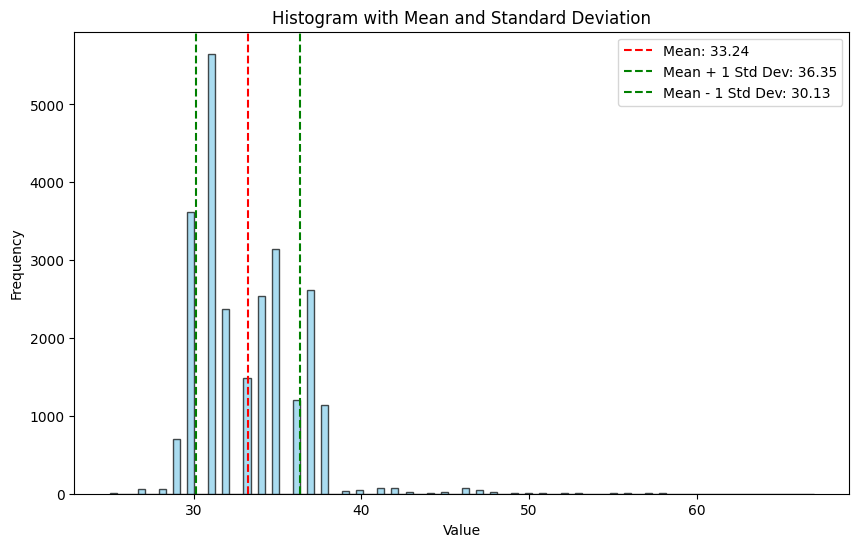

In [9]:
img = images[0]

# Example usage
border_pixels, border_pixels_2 = read_border_pixels(img)
hist_channel_1, hist_channel_2, bins_1, bins_2 = compute_histograms(border_pixels, border_pixels_2)
mean, std = plot_histogram_with_mean_std(border_pixels)

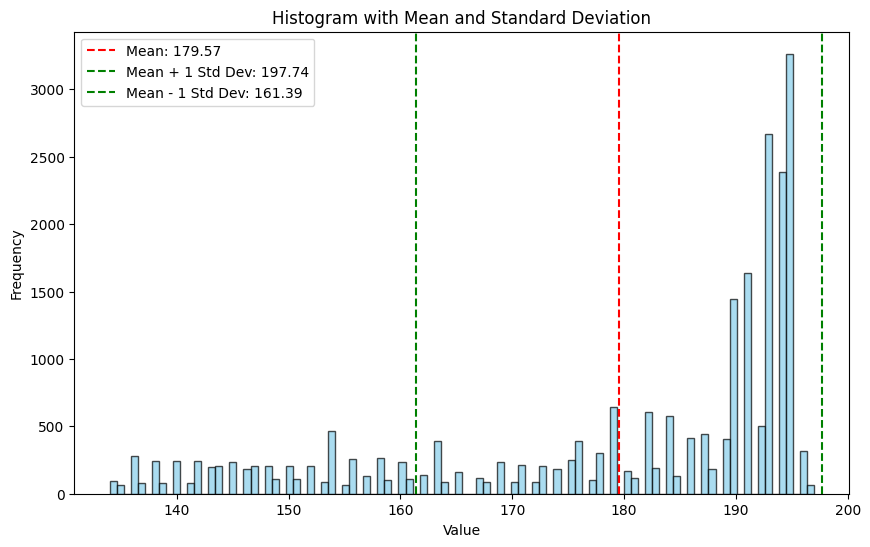

In [10]:
mean2, std2 = plot_histogram_with_mean_std(border_pixels_2)

In [11]:
reconstr = []
for row in images[0][:,:,1]:
    reconstr.append(np.array([0 if x in range(np.floor(mean-std).astype(int),np.ceil(mean+std).astype(int)) else 256 for x in row]))

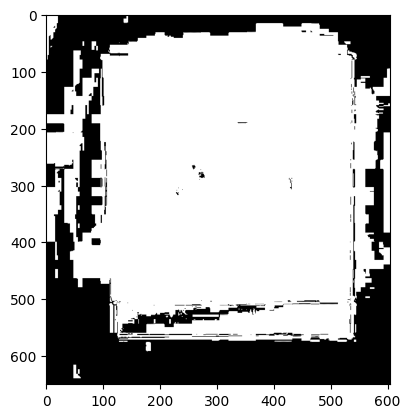

In [12]:
plt.imshow(reconstr,cmap='gray')

In [13]:
reconstr2 = []
for row in images[0][:,:,2]:
    reconstr2.append(np.array([0 if x in range(np.floor(mean2-std2).astype(int),np.ceil(mean2+std2).astype(int)) else 256 for x in row]))

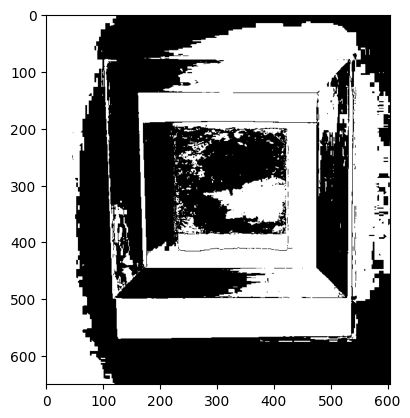

In [14]:
plt.imshow(reconstr2,cmap='gray')

In [15]:
def border_cutting(mask, pixel_border=10):
    """
    Transforms to zeroes all the values at the known pixel border
    """
    mask = np.array(mask)
    mask[:, :pixel_border] = 0
    mask[:, -pixel_border:] = 0
    mask[:10, :] = 0
    mask[-10:, :] = 0
    return mask

mask = border_cutting(reconstr)


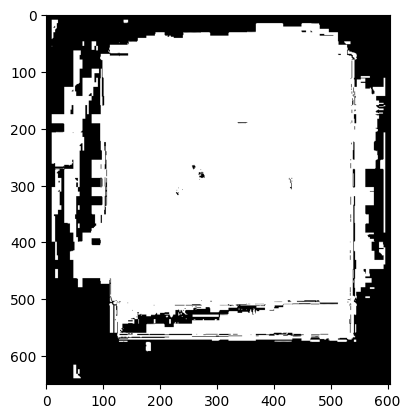

In [16]:
#10 pixels es gairebé res, que ajudara a millorar la puntació pero uf poc impacte
plt.imshow(mask,cmap='gray')

### Opening residue (diapositiva que va passar la Mireia per Discord)
He afegit una operació de closing després de fer l'opening residue perquè m'ha semblat que milloraria els resultats.

In [17]:
# We will use RGB for the opening residue
rgb_images = []
for img in images:
    rgb_images.append(cv2.cvtColor(img, cv2.COLOR_HSV2RGB))

In [18]:
def opening_residue(img, opening_kernel_size=(50, 50), closing_kernel_size=(20, 20), thres=8):
    
    grey_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Invert the image
    grey_img_neg = cv2.bitwise_not(grey_img)

    # Background: opening; (f o B)
    kernel = np.ones(opening_kernel_size, np.uint8)
    opened = cv2.morphologyEx(grey_img_neg, cv2.MORPH_OPEN, kernel)

    # Residue; f - (f o B)
    residue = cv2.subtract(grey_img_neg, opened)

    # Thresholding
    _, thresholded = cv2.threshold(residue, thres, 255, cv2.THRESH_BINARY)

    # Closed opening residue
    kernel = np.ones(closing_kernel_size, np.uint8)
    closed = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)

    plt.figure(figsize=(12, 8))
    plt.subplot(1, 5, 1)
    plt.title('Original Image')
    plt.imshow(img)

    plt.subplot(1, 5, 2)
    plt.title('Negative greyscale')
    plt.imshow(grey_img_neg, cmap='gray')

    plt.subplot(1, 5, 3)
    plt.title('Residue')
    plt.imshow(residue, cmap='gray')

    plt.subplot(1, 5, 4)
    plt.title('Thresholded residue')
    plt.imshow(thresholded, cmap='gray')

    plt.subplot(1, 5, 5)
    plt.title('Closed opening residue')
    plt.imshow(closed, cmap='gray')

    plt.tight_layout()
    plt.show()

    return thresholded


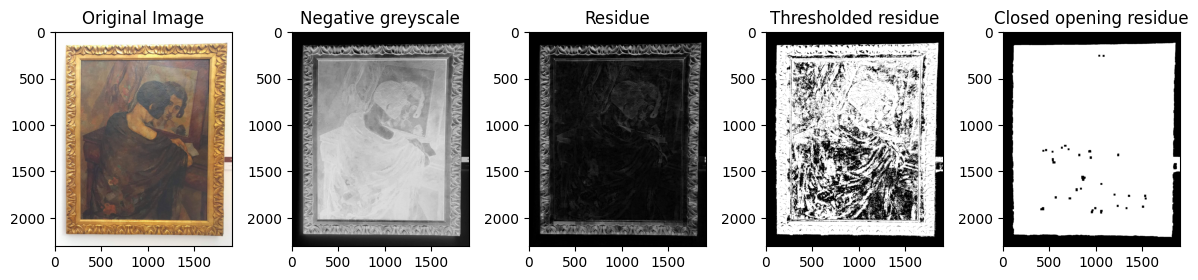

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [19]:
opening_residue(rgb_images[22])

#### Mixture of Gaussians

In [20]:
import numpy as np
from sklearn.mixture import GaussianMixture

In [21]:
image = images[0]

# Podem provar també amb HSV enlloc de Lab
image_lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)

# Vores de la imatge (amplada 10 píxels)
border_width = 10
height, width, _ = image.shape
border_pixels = np.concatenate([
    image_lab[:border_width, :, :].flatten(), # Dalt
    image_lab[-border_width:, :, :].flatten(), # Baix
    image_lab[:, :border_width, :].flatten(), # Esquerra
    image_lab[:, -border_width:, :].flatten() # Dreta
])

# Matriu Nx3 (L, a, b)
border_pixels = border_pixels.reshape(-1, 3)


In [22]:
# Mixture of gaussins ajustada als píxels de les vores
gmm = GaussianMixture(n_components=3, covariance_type='full').fit(border_pixels)

# P(pertànyer al fons) per cada píxel de la imatge
image_flat = image_lab.reshape(-1, 3)  # Imatge flattened
probs = gmm.predict_proba(image_flat)

Exception in thread Thread-7 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\mirei\miniconda3\envs\c1-project-w2\Lib\threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "c:\Users\mirei\miniconda3\envs\c1-project-w2\Lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\mirei\miniconda3\envs\c1-project-w2\Lib\threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\mirei\miniconda3\envs\c1-project-w2\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 16: invalid start byte
c:\Users\mirei\miniconda3\envs\c1-project-w2\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 

In [23]:
# Selecció de la gaussiana que representa el fons
# (Mireia: ostress, ho ho tinc clar...)
background_class = np.argmax(gmm.weights_)  # Classe amb més pes
background_probs = probs[:, background_class]  # Probabilitat de fons

# Llindar per a generar màscara de fons / quadre
threshold = 0.5  # Ajustar el llindar segons la distribució de probabilitats
mask = (background_probs < threshold).astype(np.uint8)  # Quadre = 1, Fons = 0

# Reshape de la màscara a la forma de la imatge original
mask = mask.reshape(height, width)

cv2.imshow('Segmentació', mask * 255)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Llindar adaptatiu

In [24]:
image = images[4]

# Greyscale
gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Llindar adaptatiu utilitzant la mitjana
mean_thres = cv2.adaptiveThreshold(
    gris,
    255,  # Valor màxim
    cv2.ADAPTIVE_THRESH_MEAN_C,  # Mètode de llindar adaptatiu
    cv2.THRESH_BINARY,  # Tipus de llindar
    11,  # Mida del veïnat (ha de ser senar)
    2  # Valor constant substret
)

# Llindar adapatatiu utilitzant Gaussiana
gauss_thres = cv2.adaptiveThreshold(
    gris,
    255,  # Valor màxim
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # Mètode de llindar adaptatiu
    cv2.THRESH_BINARY,  # Tipus de llindar
    11,  # Mida del veïnat (ha de ser senar)
    2  # Valor constant substret
)

# Negatiu de la imatge obtinguda
neg_mean = cv2.bitwise_not(mean_thres)
neg_gauss = cv2.bitwise_not(gauss_thres)

# Closing dels negatius
kernel = np.ones((10, 10), np.uint8)
closing_mean = cv2.morphologyEx(neg_mean, cv2.MORPH_CLOSE, kernel)
closing_gauss = cv2.morphologyEx(neg_gauss, cv2.MORPH_CLOSE, kernel)

# Mostrar resultados
cv2.imshow('Original', cv2.cvtColor(image, cv2.COLOR_HSV2BGR))
cv2.imshow('Llindar mitjana', closing_mean)
cv2.imshow('Llindar gaussià', closing_gauss)
cv2.waitKey(0)
cv2.destroyAllWindows()

#### Otsu's threshold
1. Implementació directament sobre tota la imatge, sense fer servir la informació de les vores

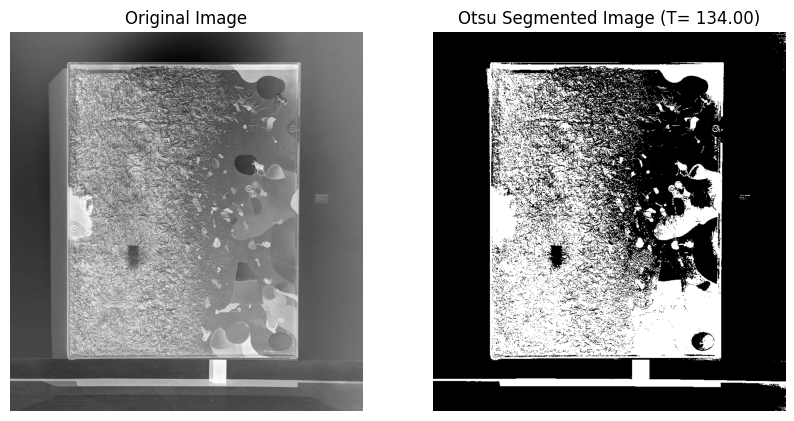

In [46]:
from skimage import io, filters
import matplotlib.pyplot as plt

# Step 1: Load the image
image = rgb_images[6]

image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# Negative image
image = cv2.bitwise_not(image)

# Step 2: Compute Otsu's threshold
otsu_threshold = filters.threshold_otsu(image)

# Step 3: Apply the threshold to segment the image
otsu_segmented = image > otsu_threshold  # Binary image based on threshold

# Step 4: Display the original and segmented images using matplotlib
plt.figure(figsize=(10, 5))

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Display Otsu segmented image
plt.subplot(1, 2, 2)
plt.imshow(otsu_segmented, cmap='gray')
plt.title(f'Otsu Segmented Image (T={otsu_threshold: .2f})')
plt.axis('off')

plt.show()


2. Llindar fent servir la informació de les vores.

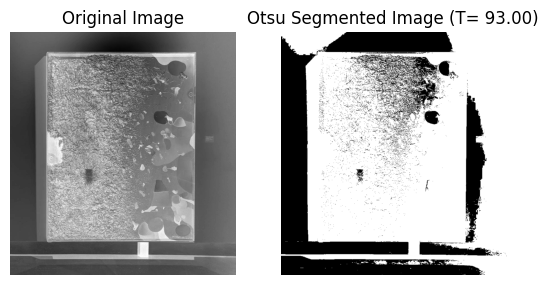

In [47]:
import cv2
import numpy as np

# Cargar la imagen
imagen = rgb_images[6]

# Convertir la imagen a escala de grises (Otsu normalmente se usa en imágenes en escala de grises)
gris = cv2.cvtColor(imagen, cv2.COLOR_RGB2GRAY)

# Negative image
gris = cv2.bitwise_not(gris)

# Extraer los píxeles de los bordes (10 píxeles de cada borde)
borde_superior = gris[:10, :]  # 10 filas desde el borde superior
borde_inferior = gris[-10:, :]  # 10 filas desde el borde inferior
borde_izquierdo = gris[:, :10]  # 10 columnas desde el borde izquierdo
borde_derecho = gris[:, -10:]  # 10 columnas desde el borde derecho

# Crear una lista con todos los píxeles de los bordes
# Convertimos cada borde en un array unidimensional antes de concatenarlos
pixeles_borde = np.concatenate((
    borde_superior.flatten(),  # Aplanamos el borde superior
    borde_inferior.flatten(),  # Aplanamos el borde inferior
    borde_izquierdo.flatten(),  # Aplanamos el borde izquierdo
    borde_derecho.flatten()  # Aplanamos el borde derecho
))

# Aplicar Otsu solo a los píxeles de los bordes
umbral_fondo, _ = cv2.threshold(pixeles_borde, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Aplicar el umbral a toda la imagen usando el valor de Otsu calculado
_, imagen_segmentada = cv2.threshold(gris, umbral_fondo, 255, cv2.THRESH_BINARY)

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(gris, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Display Otsu segmented image
plt.subplot(1, 2, 2)
plt.imshow(imagen_segmentada, cmap='gray')
plt.title(f'Otsu Segmented Image (T={umbral_fondo: .2f})')
plt.axis('off')

plt.show()
